<a href="https://colab.research.google.com/github/abdulkk49/Graph-Convolutional-Networks/blob/master/GCN_pytorchGeometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvcc --version #check nvcc version

In [0]:
# Install pytorch geometric and tensorboardX

# !pip install --verbose --no-cache-dir torch-scatter
# !pip install --verbose --no-cache-dir torch-sparse
# !pip install --verbose --no-cache-dir torch-cluster
# !pip install torch-geometric
# !pip install tensorboardX
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

In [51]:
# CORA is a dataset of academic papers of seven different classes. 
# It contains the citation relations between the papers as well as
# a binary vector for each paper that specifies if a word occurs in 
# the paper. Thus, CORA contains both content-based features for each paper 
# and relationship features between the papers.

# We can model these features with a network where each paper is 
# represented by a node that carries the content-based features and citations are represented with edges.

# pytorch geometric already has this dataset in its library.
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
print("Length of dataset(Number of graphs): ", len(dataset))
print("Number of classes: ", dataset.num_classes)
print("Number of features in a node: ", dataset.num_node_features)

Length of dataset(Number of graphs):  1
Number of classes:  7
Number of features in a node:  1433


In [105]:
# Getting graph and its general information
data = dataset[0]
# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
print("Has isolated nodes: ", data.contains_isolated_nodes())
print("Is directed?: ", data.is_directed())
print("Number of nodes: ", data.num_nodes)
print("Semi Supervised Learning Params...")
print("Number of nodes to train on: ", data.train_mask.sum().item())
print("Number of nodes to validate on: ", data.val_mask.sum().item())
print("Number of nodes to test on: ", data.test_mask.sum().item())

Has isolated nodes:  False
Is directed?:  False
Number of nodes:  2708
Semi Supervised Learning Params...
Number of nodes to train on:  140
Number of nodes to validate on:  500
Number of nodes to test on:  1000


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [0]:
def training(model, optimizer):
  all_logits = []
  for epoch in range(201):
      total_loss = 0
      optimizer.zero_grad()
      embedding, pred = model(data)
      all_logits.append(embedding.detach())
      pred = pred[data.train_mask]
      label = data.y[data.train_mask]
      loss = model.loss(pred, label)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

      if epoch % 10 == 0:
          model.eval()
          _, pred = model(data)
          pred = pred.argmax(dim=1)
          correct_train = float (pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
          acc_train = correct_train / data.train_mask.sum().item()
          correct_test = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
          acc_test = correct_test / data.test_mask.sum().item()
          print("Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}".format(
              epoch, total_loss, acc_train, acc_test))

  return all_logits

def visualize(i, all_logits):
  color_list = ["red", "orange", "green", "blue", "purple", "brown"]
  embs = []
  colors = []
  emb = all_logits[i]
  print(emb.shape)
  print(pred.shape)
  embs.append(emb)
  colors += [color_list[y-1] for y in batch.y]
  embs = torch.cat(embs, dim=0)
  if device == torch.device('cuda'):
    embs = torch.Tensor.cpu(embs)
  xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
  plt.scatter(xs, ys, color=colors)

In [0]:
# Model 1

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        # number of layers in netowrk
        self.num_layers = 3
        # set drop-out probability anf number of layers
        self.dropout = 0.25
        # create a module list as per pytorch specifications for GCN layers
        self.convs = nn.ModuleList()
        # add GCN layers
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        for l in range(self.num_layers - 1):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))
        
        # create a module list for Normalization layers
        self.lns = nn.ModuleList()
        # add 2 Normalization layers
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))

        #final layers
        self.final = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))

    def build_conv_model(self, input_dim, hidden_dim):
            return pyg_nn.GCNConv(input_dim, hidden_dim)

    def forward(self, data):
        # unpack node features, edges and batches
        x, edge_index = data.x, data.edge_index

        # if no no features preent, add a single feature for representation
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        # each forward pass, we have
        # GCN layer --> relu --> dropout --> normalization(not in last GCN layer)
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p = self.dropout, training=self.training)
            # add nomalization to non last GCN layers
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        x = self.final(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [156]:
model1 = GNN(max(dataset.num_node_features, 1), 32, dataset.num_classes).to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01, weight_decay=5e-4)
is_val = False
# set to train
model1.train()
all_logits1 = training(model1, optimizer1)

Epoch 0. Loss: 1.9798. Train accuracy: 0.3786. Test accuracy: 0.2060
Epoch 10. Loss: 0.1554. Train accuracy: 0.9857. Test accuracy: 0.7730
Epoch 20. Loss: 0.0010. Train accuracy: 1.0000. Test accuracy: 0.7190
Epoch 30. Loss: 0.0001. Train accuracy: 1.0000. Test accuracy: 0.7030
Epoch 40. Loss: 0.0000. Train accuracy: 1.0000. Test accuracy: 0.7030
Epoch 50. Loss: 0.0000. Train accuracy: 1.0000. Test accuracy: 0.7080
Epoch 60. Loss: 0.0000. Train accuracy: 1.0000. Test accuracy: 0.7150
Epoch 70. Loss: 0.0001. Train accuracy: 1.0000. Test accuracy: 0.7160
Epoch 80. Loss: 0.0001. Train accuracy: 1.0000. Test accuracy: 0.7200
Epoch 90. Loss: 0.0001. Train accuracy: 1.0000. Test accuracy: 0.7200
Epoch 100. Loss: 0.0001. Train accuracy: 1.0000. Test accuracy: 0.7220
Epoch 110. Loss: 0.0001. Train accuracy: 1.0000. Test accuracy: 0.7230
Epoch 120. Loss: 0.0002. Train accuracy: 1.0000. Test accuracy: 0.7230
Epoch 130. Loss: 0.0002. Train accuracy: 1.0000. Test accuracy: 0.7180
Epoch 140. Loss: 

torch.Size([2708, 32])
torch.Size([2708, 7])


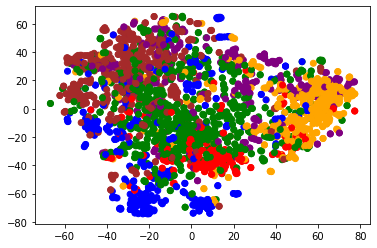

In [157]:
visualize(199, all_logits1)

In [0]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
ani = animation.FuncAnimation(fig, visualize, frames=len(all_logits[190:194]), interval=200)
from matplotlib import rc
rc('animation', html='jshtml')
ani

In [0]:
# Model 2
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = pyg_nn.GCNConv(dataset.num_node_features, 16)
        self.conv2 = pyg_nn.GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        emb = x
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [151]:
model2 = Net().to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01, weight_decay=5e-4)
is_val = False    
# train
model2.train()
all_logits2 = training(model2, optimizer2)

Epoch 0. Loss: 1.9384. Train accuracy: 0.5357. Test accuracy: 0.4320
Epoch 10. Loss: 0.7052. Train accuracy: 0.9571. Test accuracy: 0.7430
Epoch 20. Loss: 0.1537. Train accuracy: 1.0000. Test accuracy: 0.7850
Epoch 30. Loss: 0.0348. Train accuracy: 1.0000. Test accuracy: 0.7870
Epoch 40. Loss: 0.0163. Train accuracy: 1.0000. Test accuracy: 0.7890
Epoch 50. Loss: 0.0137. Train accuracy: 1.0000. Test accuracy: 0.8000
Epoch 60. Loss: 0.0148. Train accuracy: 1.0000. Test accuracy: 0.8040
Epoch 70. Loss: 0.0166. Train accuracy: 1.0000. Test accuracy: 0.8050
Epoch 80. Loss: 0.0173. Train accuracy: 1.0000. Test accuracy: 0.8050
Epoch 90. Loss: 0.0170. Train accuracy: 1.0000. Test accuracy: 0.8080
Epoch 100. Loss: 0.0161. Train accuracy: 1.0000. Test accuracy: 0.8060
Epoch 110. Loss: 0.0152. Train accuracy: 1.0000. Test accuracy: 0.8080
Epoch 120. Loss: 0.0143. Train accuracy: 1.0000. Test accuracy: 0.8060
Epoch 130. Loss: 0.0136. Train accuracy: 1.0000. Test accuracy: 0.8040
Epoch 140. Loss: 

torch.Size([2708, 32])
torch.Size([2708, 7])


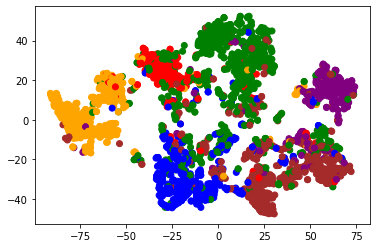

In [166]:
visualize(199, all_logits2)